In [107]:
using DataFrames, Statistics, LinearAlgebra, Plots, CategoricalArrays, Distances
using JLD, Distributions, JSON, HTTP, StatsPlots, StatsBase, Parquet, CSV

In [46]:
codebook = CSV.read(download("https://envbran.s3.us-east-2.amazonaws.com/codebook.tsv"), DataFrame);
phenotype = CSV.read(download("https://envbran.s3.us-east-2.amazonaws.com/phenotype.tsv"), DataFrame);
met_urine = CSV.read(download("https://envbran.s3.us-east-2.amazonaws.com/met_urine.tsv"), DataFrame);
exposure = CSV.read(download("https://envbran.s3.us-east-2.amazonaws.com/covariates.tsv"), DataFrame);

In [47]:
tmp = filter([:period, :var_type, :domain, :period_postnatal, :family, :subfamily] => (x,y,z,w,p,r) -> x == "Postnatal" && 
        y == "numeric" && z != "Covariates" && z!= "Phenotype" && (w == "NA" || contains.(w, "Year")) && 
       !(contains.(p,"Traffic") || contains.(p,"Social and economic capital") || contains.(p,"Built environment") || 
        contains.(p,"Indoor air") || contains.(p,"Lifestyle") || contains.(p,"Natural Spaces")),
        codebook);

In [48]:
var_name = vcat("ID",tmp.variable_name)
environmental = exposure[:,var_name];

In [49]:
met_urine = permutedims(met_urine[:,vcat(1,8:1199)],1)
names(met_urine)[2:45];

In [50]:
met_urine.rn = parse.(Int64, met_urine.rn);

In [51]:
DT = innerjoin(environmental, met_urine, on = :ID => :rn);
names(DT);

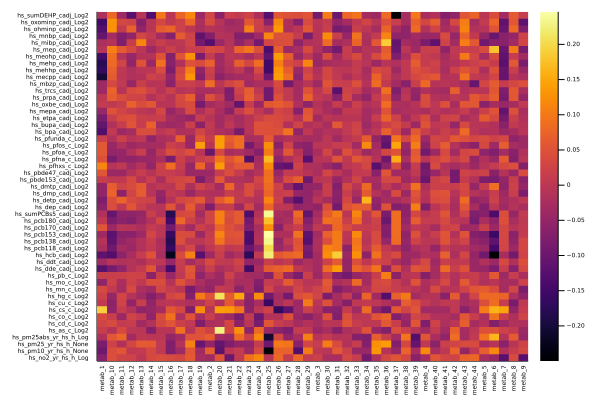

In [55]:
M = cor(Matrix{Float64}(DT[:,2:size(DT)[2]]))       # correlation matrix
MC = Matrix{Float64}(M[1:(length(var_name)-1),length(var_name):(length(var_name)+43)])
# PLOT
var_name_ = tmp.variable_name
met_urine_ = names(met_urine)[2:45]
(n,m) = size(MC)
heatmap(MC;# fc=cgrad([:white,:dodgerblue4]); 
        yticks=(1:n,var_name_), xrot=90, 
        xticks=(1:m,met_urine_), size = (600, 400),tickfontsize = 4)

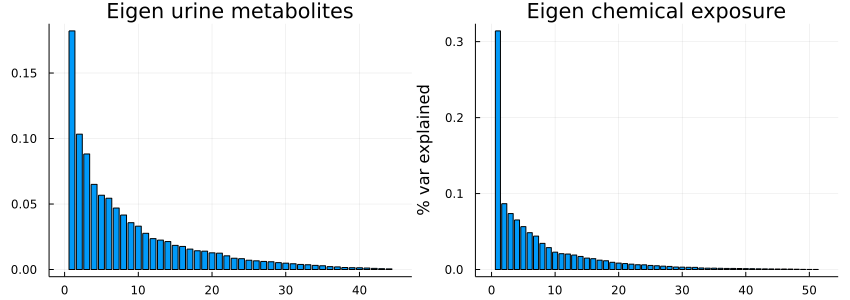

In [60]:
MU = Matrix{Float64}(met_urine[:,2:45])
eig_MU = eigen(cov(MU))
tmp_bar = sort(eig_MU.values/sum(eig_MU.values),rev = true)
p = bar(1:44,tmp_bar, #ylabel = "% var explained",xlabel = "Components",
    title = "Eigen urine metabolites")

MCh = Matrix{Float64}(environmental[:,2:52])
eig_MCh = eigen(cov(MCh))
tmp_bar = sort(eig_MCh.values/sum(eig_MCh.values),rev = true)
q = bar(1:51,tmp_bar, ylabel = "% var explained",
        #xlabel = "Components",
        title = "Eigen chemical exposure")

plot(p, q, layout = (1, 2), legend = false, size = (850, 300))

In [129]:
met_serum = CSV.read(download("https://envbran.s3.us-east-2.amazonaws.com/met_serum.tsv"), DataFrame);
#names(met_serum)
X = Matrix(Matrix{Float64}(met_serum[:,4:1201])');
#X .- mean(X,dims=1)

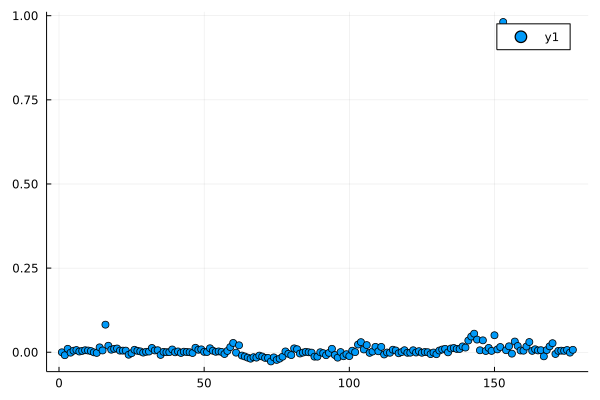

In [132]:
X = X .- mean(X,dims=1)
Y = (X'*X)./1197
eigvals, eigvecs = eigen(Y)
W = eigvecs[:,177]
scatter(W)

In [168]:
using MultivariateStats

# suppose Xtr and Xte are training and testing data matrix,
# with each observation in a column

# train a kernel PCA model
# M = fit(KernelPCA, X; maxoutdim=100, inverse=true)
M = fit(PCA, Matrix(X'); maxoutdim=100);

# apply kernel PCA model to testing set
#Yte = transform(M, Xte)

# reconstruct testing observations (approximately)
#Xr = reconstruct(M, Yte)
M.proj

177×100 Matrix{Float64}:
 -0.000151108  -0.0275545   0.534102    …  -0.00207609   0.00609331
 -0.00881116   -4.932e-5    0.123141       -0.169034    -0.0524207
  0.0102187    -0.0824809  -0.012743        0.017605     0.196735
 -0.00125163   -0.0898477  -0.00575273     -0.0254296    0.0905192
  0.00460493   -0.0715574   0.0465835      -0.0661712   -0.0723208
  0.00653684   -0.0925781  -0.0109472   …   0.109113    -0.0312113
  0.00214692   -0.12093    -0.0960982       0.00747351  -0.0480839
  0.00403656   -0.084968   -0.0133776       0.0471536   -0.0377666
  0.00592848   -0.0899368  -0.0144453       0.0895096   -0.0663961
  0.00512682   -0.0885795  -0.0245734       0.191435     0.0169505
  0.0034451    -0.0751189   0.0189725   …  -0.245966    -0.150592
 -0.000240932  -0.0979078  -0.0455129       0.0283519   -0.0493603
 -0.00200698   -0.0159869  -0.00517934      0.0608033   -0.000143284
  ⋮                                     ⋱               
  0.0061023    -0.0760659   0.0576745   …  -0.

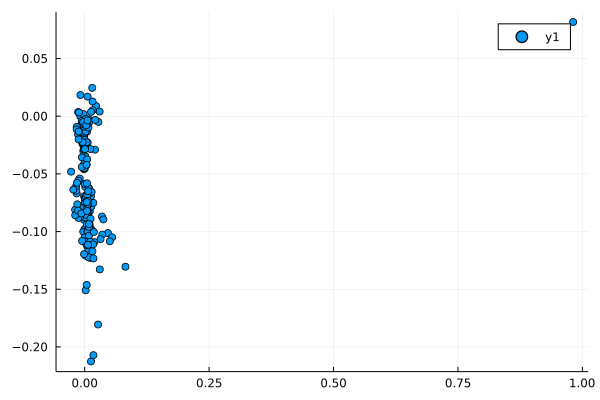

In [169]:
scatter(M.proj[:,1],M.proj[:,2])

In [174]:
# Kernel PCA
dX = pairwise(sqeuclidean, Matrix(X'), dims=2)

1198×1198 Matrix{Float64}:
   0.0      30.6138   87.5171   24.9051  …   43.0237   37.4789   51.0213
  30.6138    0.0      91.3051   22.1067      27.2942   40.1674   68.5937
  87.5171   91.3051    0.0      91.4364     133.632    70.7182   92.9161
  24.9051   22.1067   91.4364    0.0         36.4289   48.9535   68.8081
  47.5523   43.609   163.935    43.4156      36.405    75.4587   88.9298
  42.715    47.5089   56.6771   48.0357  …   82.2399   33.7348   35.1001
  43.992    53.7509   79.3368   54.3263      73.6718   23.2081   45.8236
  30.5545   33.6647   98.0748   26.7989      38.3736   43.8206   51.1816
  46.8488   43.6525  115.272    49.0413      53.0139   42.9721   37.8024
  29.6398   44.8169   62.8406   34.565       68.1011   30.6915   39.005
  37.4109   46.6643   67.0231   45.1502  …   63.4089   25.8032   32.7344
  41.4399   53.9872   69.9312   51.605       87.4371   28.0964   32.8404
  23.8096   28.9475   99.7271   23.7261      35.4619   42.0346   47.4246
   ⋮                     

In [175]:
K = exp.(-0.001 * dX);

In [176]:
# Centering the symmetric NxN kernel matrix.
N = size(K)[1]
one_n = ones((N,N)) / N
K = K - one_n * K - K * one_n + one_n * K * one_n
# Obtaining eigenvalues in descending order with corresponding
# eigenvectors from the symmetric matrix.
eigvals_n, eigvecs_n = eigen(K)

Eigen{Float64, Float64, Matrix{Float64}, Vector{Float64}}
values:
1198-element Vector{Float64}:
  2.9668344543912555e-13
  4.7356878680130255e-5
  4.77757453918324e-5
  4.909526743103953e-5
  5.024892825186285e-5
  5.11710737448581e-5
  5.2571711108203364e-5
  5.287232941385943e-5
  5.310660142877548e-5
  5.3539368784639616e-5
  5.442862625851286e-5
  5.4843162931210194e-5
  5.496228799735291e-5
  ⋮
  1.3749291966665271
  1.652917780540377
  1.7482165650273498
  1.9614931115321361
  1.981031184199743
  2.263154987652124
  2.6226436452580217
  3.3722112594690685
  4.360742598773917
  4.707372891014755
  9.907698498093023
 19.171565238466652
vectors:
1198×1198 Matrix{Float64}:
 -0.0288916   0.0154889    -0.0218489    …  -0.0187647   -0.0104346
 -0.0288916   0.0225164     0.00406336      -0.031648    -0.0101494
 -0.0288916   0.00525464   -0.0123187        0.0612128    0.037027
 -0.0288916  -0.00939994   -0.00486374      -0.0316574   -0.0115591
 -0.0288916  -0.0158523     0.0114768       -

In [178]:
W = eigvecs_n[:,1197:1198]

1198×2 Matrix{Float64}:
 -0.0187647   -0.0104346
 -0.031648    -0.0101494
  0.0612128    0.037027
 -0.0316574   -0.0115591
 -0.0756157   -0.0141505
  0.0349321   -0.00885996
  0.0280174   -0.0256399
 -0.0338359   -0.0133608
 -0.0212746   -0.0151801
  0.0203077   -0.0109385
  0.0229584   -0.0214449
  0.0352935   -0.0218511
 -0.0358696   -0.0100079
  ⋮           
  0.00670891  -0.0243685
 -0.0178941   -0.0229382
 -0.00200071  -0.00946171
 -0.0277404   -0.015596
 -0.036598    -0.00488785
  0.027235     0.0653357
 -0.0540825    0.00716954
 -0.0243351   -0.0204503
 -0.0231215   -0.00368469
 -0.0596802   -0.0132525
  0.0214498   -0.0187964
  0.0285373   -0.0249391

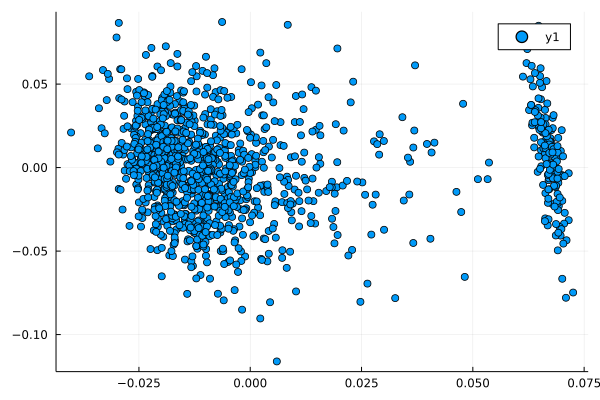

In [179]:
scatter(W[:,2],W[:,1])